# Poisonous Mushroom Decision Trees
**Dataset from https://archive.ics.uci.edu/dataset/73/mushroom**

**Compares the performance of 3 decision tree models on the categorical mushroom classification dataset**

In [ ]:
# Install package to fetch dataset
!pip install ucimlrepo

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

## Read data

In [87]:
from ucimlrepo import fetch_ucirepo

dataset = fetch_ucirepo(id=73)
df = pd.DataFrame(dataset.data.features, columns=dataset.feature_names)

df['class'] = dataset.data.targets
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


### Data Exploration Plots

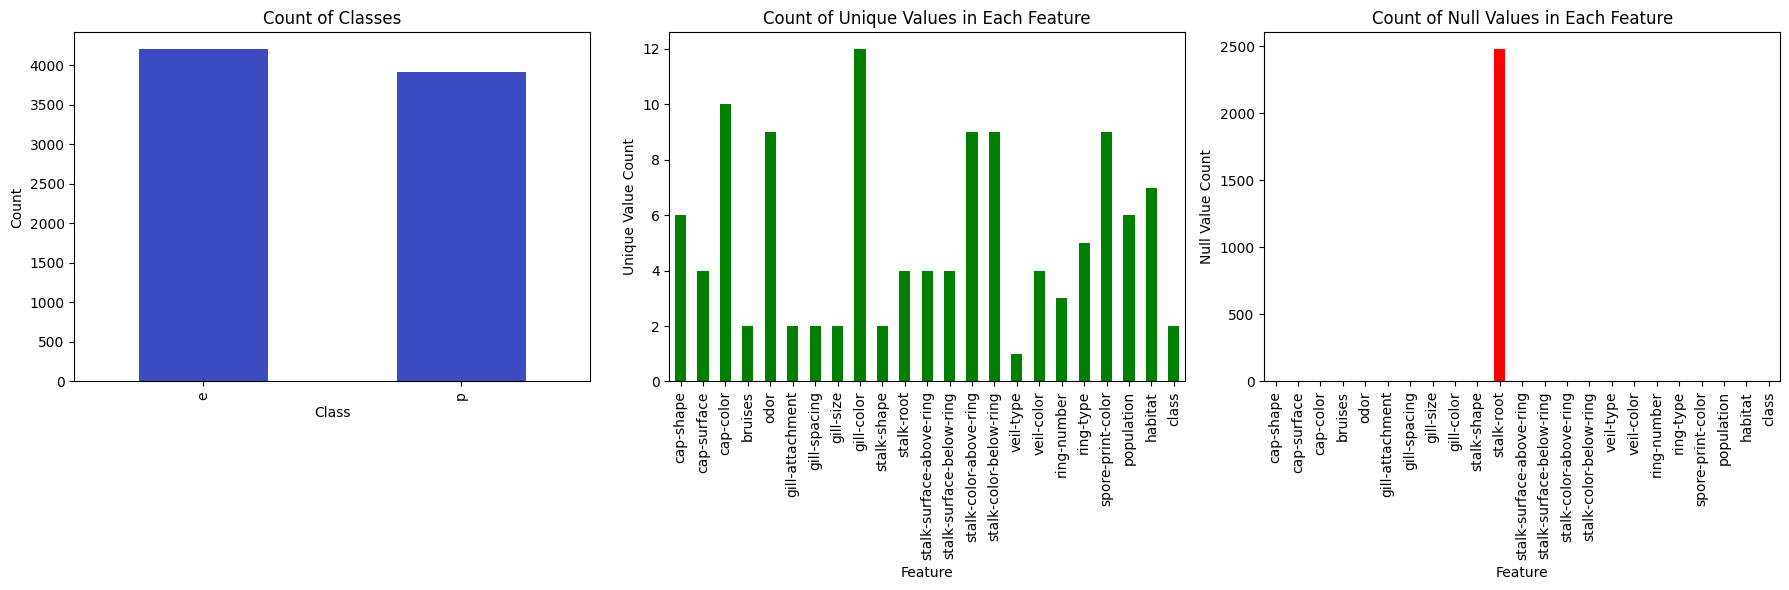

In [88]:
# Plot count of classes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 3 side-by-side subplots
df['class'].value_counts().plot(kind='bar', stacked=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Count of Classes')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Plot unique values in each feature
unique_counts = df.nunique()
unique_counts.plot(kind='bar', color='green', ax=axes[1])
axes[1].set_title('Count of Unique Values in Each Feature')
axes[1].set_xlabel('Feature')
axes[1].set_ylabel('Unique Value Count')

# Plot null values in each feature
null_counts = df.isnull().sum()
null_counts.plot(kind='bar', color='red', ax=axes[2])
axes[2].set_title('Count of Null Values in Each Feature')
axes[2].set_xlabel('Feature')
axes[2].set_ylabel('Null Value Count')

# Adjust layout
plt.tight_layout()
plt.show()

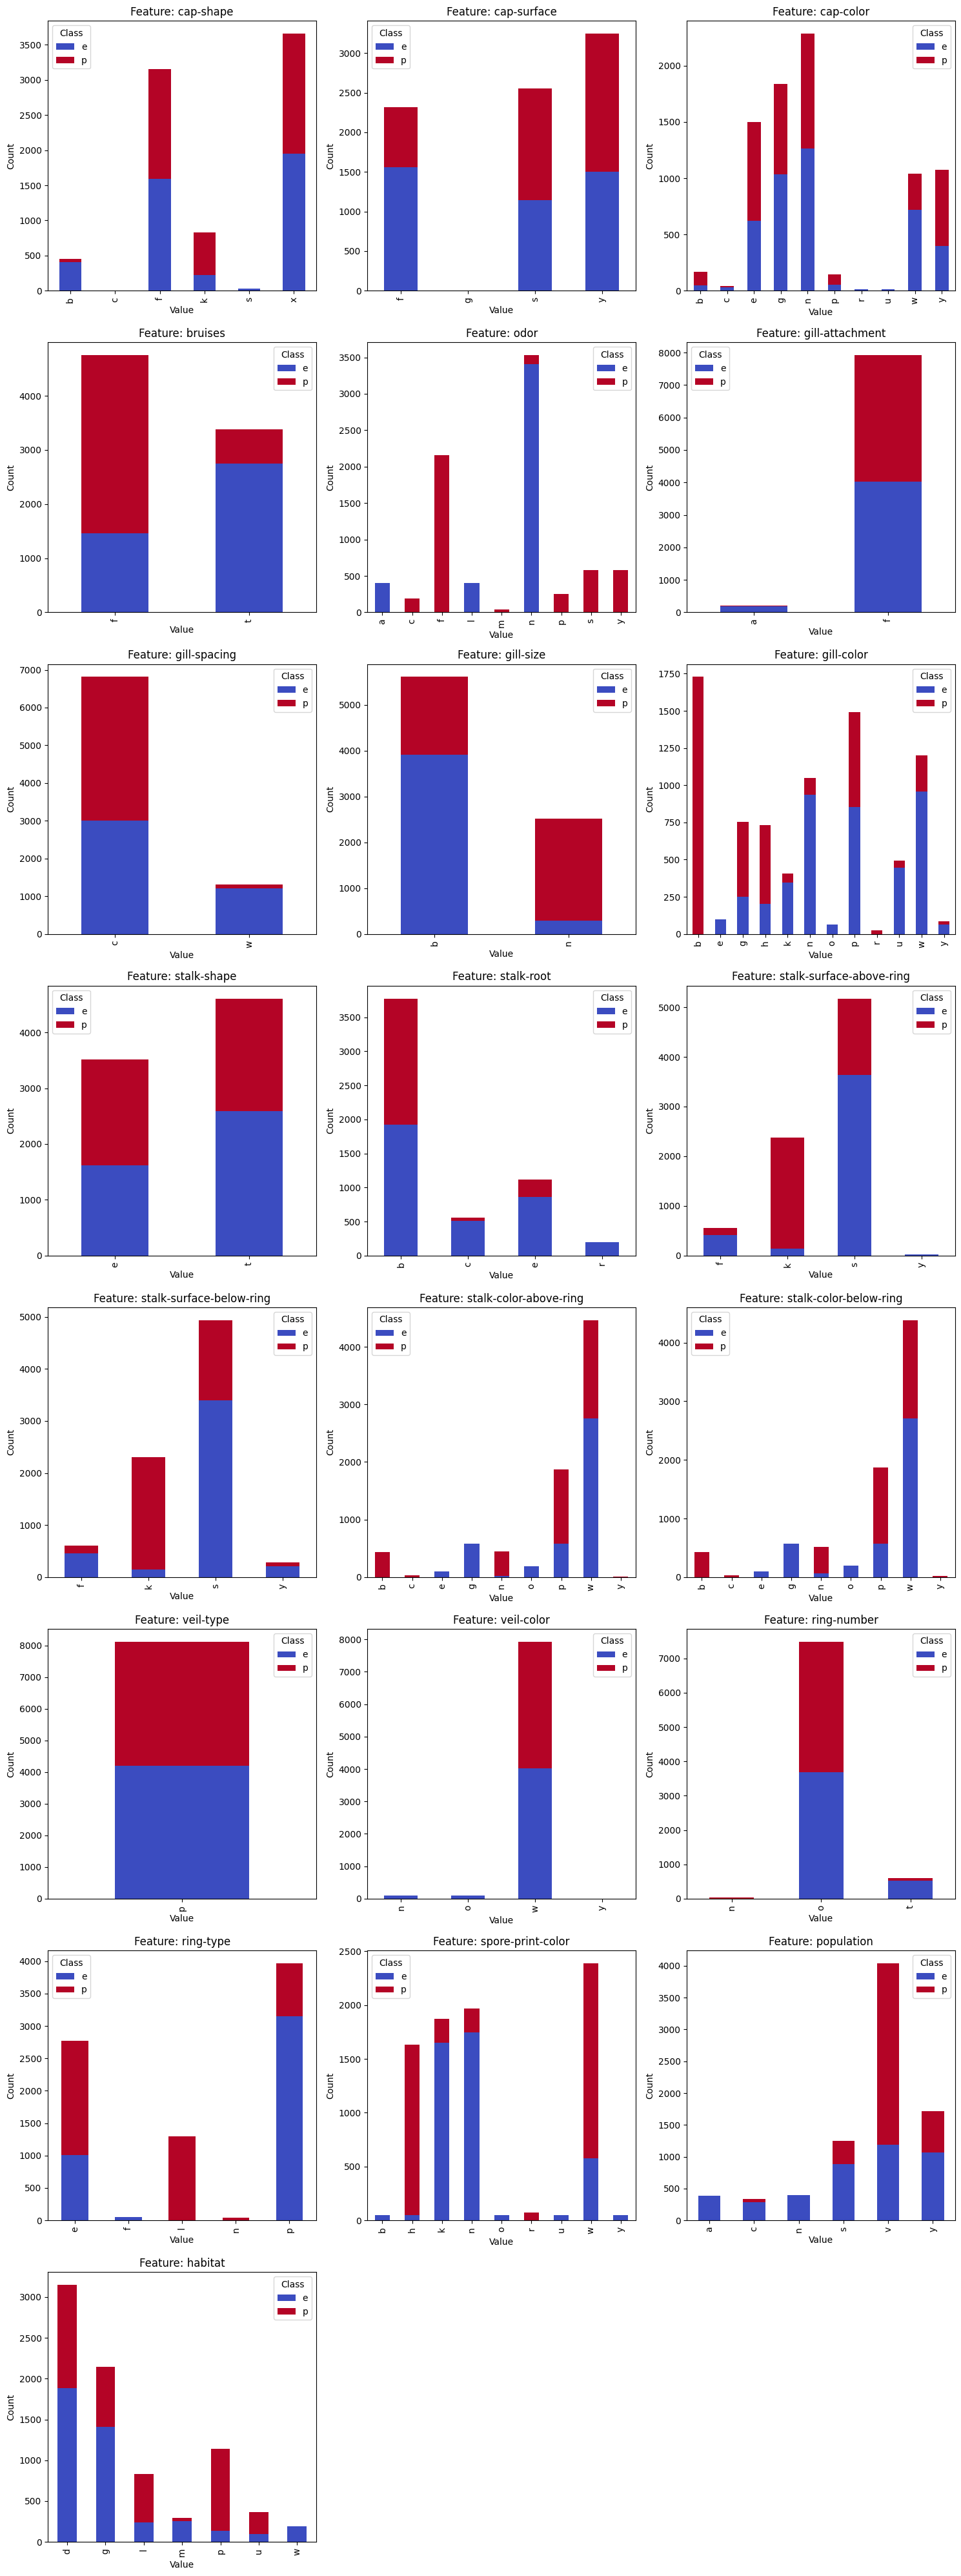

In [89]:
# Plot class distribution for each feature
num_columns = 3
num_rows = (len(df.columns) - 1) // num_columns + 1  # num rows needed
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

for i, column in enumerate(df.columns[:-1]):  # excluding the 'class' column
    ax = axes[i // num_columns, i % num_columns]
    df.groupby(column)['class'].value_counts(dropna=False).unstack().plot(kind='bar', stacked=True, ax=ax, cmap='coolwarm')
    ax.set_title(f'Feature: {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.legend(title='Class')

# Remove empty subplots
for j in range(i + 1, num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.tight_layout()
plt.show()

## Encode Categorical Data

In [90]:
# Split data into features and target (X and y)
y = df['class']
X = df.drop(labels=['class'],axis=1)

# Remove columns with null values
X = X.drop(labels=X.columns[X.isnull().any()], axis=1)

# Convert categorical data into one-hot encoding
X = pd.get_dummies(X)
X.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,False,False,False,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False


## Train Decision Tree Models

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split( X , y , test_size = 0.2, random_state = 42)

In [92]:
# Train Decision Tree and find best hyperparameters with a criterion
def explore_decision_tree_hyperparams(X_train, X_test, Y_train, Y_test, criterion):
    depths = range(2, 16)
    samples = range(1, 30)
    best_acc = 0
    best_params = None

    for max_depth in depths:
        for min_samples_leaf in samples:
            clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            clf.fit(X_train, Y_train)
            Yp_test = clf.predict(X_test)
            accuracy = accuracy_score(Y_test, Yp_test)

            if accuracy > best_acc:
                best_acc = accuracy
                best_clf = clf

    return best_clf, Yp_test

# Train Random Forest and find best hyperparameters
def explore_random_forest_hyperparams(X_train, X_test, Y_train, Y_test):
    estimators = [3, 10, 50]
    depths = [8, 9, 10, 11, 12, 13, 14, 15]
    samples = [i for i in range(1, 30)]

    best_acc = 0
    best_max_depth = 0
    best_n_estimators = 0

    for max_depth in depths:
      for n_estimators in estimators:
        for min_samples_leaf in samples:
          clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
          clf.fit(X_train, Y_train)
          Yp_test = clf.predict(X_test)
          accuracy = accuracy_score(Y_test, Yp_test)

          if accuracy > best_acc:
            best_acc = accuracy
            best_clf = clf

    return best_clf, Yp_test

# Print classifier, confusion matrix, and classification report
def print_performance(best_clf, Y_test, Yp_test):
    print("Best:\n", best_clf)
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Yp_test))
    print("Report:\n", classification_report(Y_test, Yp_test))

### Train with Gini Index

In [93]:
clf_gini, Yp_gini = explore_decision_tree_hyperparams(X_train, X_test, Y_train, Y_test, criterion="gini")
print_performance(clf_gini, Y_test, Yp_gini)

Best:
 DecisionTreeClassifier(max_depth=4)
Confusion Matrix:
 [[840   3]
 [  1 781]]
Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### Train with Entropy

In [94]:
clf_entropy, Yp_entropy = explore_decision_tree_hyperparams(X_train, X_test, Y_train, Y_test, criterion='entropy')
print_performance(clf_entropy, Y_test, Yp_entropy)

Best:
 DecisionTreeClassifier(criterion='entropy', max_depth=5)
Confusion Matrix:
 [[840   3]
 [  1 781]]
Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### Train with Random Forest

In [95]:
clf_random, Yp_random = explore_random_forest_hyperparams(X_train, X_test, Y_train, Y_test)
print_performance(clf_random, Y_test, Yp_random)

Best:
 RandomForestClassifier(max_depth=8, min_samples_leaf=14, n_estimators=10,
                       random_state=42)
Confusion Matrix:
 [[843   0]
 [  2 780]]
Report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       843
           p       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



## Cross Validation

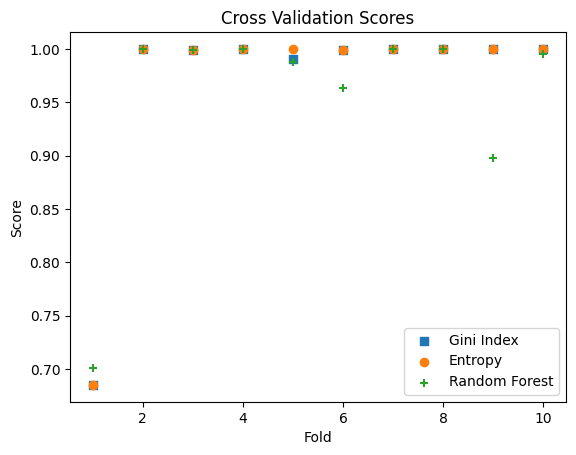

In [96]:
cv = 10
scores_gini = cross_val_score(clf_gini, X, y, cv=cv)
scores_entropy = cross_val_score(clf_entropy, X, y, cv=cv)
scores_random = cross_val_score(clf_random, X, y, cv=cv)

x = np.arange(1, len(scores_gini)+1, 1)
plt.scatter(x, scores_gini, label='Gini Index', marker='s')
plt.scatter(x, scores_entropy, label='Entropy', marker='o')
plt.scatter(x, scores_random, label='Random Forest', marker='+')
plt.legend()
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Cross Validation Scores")
print()
plt.show()